# Advanced Prompting: Chain of Thought and ReAct (Reasoning + Acting)


In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
<td style="text-align: center">
<a href="https://colab.research.google.com/github/GoogleCloudPlatform/applied-ai-engineering/blob/main/genai-on-vertex/advanced_prompting_training/cot_react.ipynb">
<img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
</a>
</td>
<td style="text-align: center">
<a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering/blob/main/genai-on-vertex/advanced_prompting_training/cot_react.ipynb">
<img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
</a>
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering/blob/main/genai-on-vertex/advanced_prompting_training/cot_react.ipynb">
<img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
</a>
</td>
</table>

| | |
|----------|-------------|
| Author(s)   | Michael W. Sherman |
| Reviewers(s) | Rajesh Thallam |
| Last updated | 2023 10 18: Cleanup for public sharing. |
| | 2023 10 06: Edits for length and clarity. |
| | 2023 09 30: Initial version. |

# Part 0: Introduction

The target audience of this notebook are engineering prompts to repeatedly execute a task, workflow, process, function, etc. Stability and performance are more important than when prompting for a one-off need.

This notebook covers two powerful LLM prompting strategies: **Chain of Thought** and **ReAct** (Reasoning + Acting).

ReAct (and its variants) are the current state-of-the-art prompting technique to improve LLM reasoning while minimizing hallucinations.

The four parts of this notebook are are:

1. Chain-of-Thought Prompting: Using language descriptions of reasoning to improve LLM outputs.
1. Actions, Retrieval, and Tool Use: How LLMs interact with external systems.
1. ReAct (Reasoning + Acting) Prompting: Combining the written reasoning descriptions of chain-of-thought prompting with external system interactions.
1. Langchain and ReAct: What to expect when using Langchain ReAct agents.

This notebook was tested in Colab.

## How to Use This Notebook

* Run part 0 first.
* Parts 1-4 each depend on the code in part 0, but do not depend on the code in other previous parts.


## Prerequisites

- An understanding of LLMs (large language models):
 - What an LLM is and how they work.
 - LLMs as repetitive next-token predictors.  
 - LLM predictions maximize resemblance to the training data.
- Experience with LLM prompting:
 - What it means to "prompt" a language model. [Recommended resource](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/introduction-prompt-design).
 - The difference between [zero-shot, one-shot, and few-shot](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/introduction-prompt-design#include-examples) prompting, and an understanding why few-shot prompting is essential for maximizing performance and robustness.
- Basic familiarity with Google Cloud Vertex LLMs. [Recommended resource](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart)
- Know what Langchain is and the problems it aims to solve.
 - [Recommended resource](https://python.langchain.com/docs/get_started/introduction) and [tutorials](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/language/orchestration/langchain).

## Key Terminology

For consistency this notebook uses the following terms in specific ways:

* **Prompt**: A templated LLM call, created using specific techniques that maximize the performance and robustness of the call regardless of what values are inserted into the template.
* **LLM Call**: Sending text to an LLM.
* **LLM Response**: Text predicted by the LLM, what comes back from the LLM when making an LLM call.
* **Chain/Chaining** Depending on context:
 * In chain-of-thought prompting, logically sequential steps of reasoning.
 * In LLM systems, sequential calls to an LLM, where each call depends on a previous call's response.
* **Exemplar**: An "example" in a one- or few-shot prompt.
 * Used to avoid confusion with "example" in the traditional ML sense, i.e., "a piece of data" (as in "training examples").

## References

* Kojima, Takeshi, et al. "Large language models are zero-shot reasoners." Advances in neural information processing systems 35 (2022): 22199-22213. [Link](https://arxiv.org/abs/2205.11916) (accessed 2023 09 22)
* Wang, Xuezhi, et al. "Self-consistency improves chain of thought reasoning in language models." arXiv preprint arXiv:2203.11171 (2022). [Link](https://arxiv.org/abs/2203.11171) (accessed 2023 09 03).
* Wei, Jason, et al. "Chain-of-thought prompting elicits reasoning in large language models." Advances in Neural Information Processing Systems 35 (2022): 24824-24837. [Link](https://arxiv.org/abs/2201.11903) (accessed 2023 09 03).
* Yao, Shunyu, et al. "React: Synergizing reasoning and acting in language models." arXiv preprint arXiv:2210.03629 (2022). [Link](https://arxiv.org/abs/2210.03629) (accessed 2023 09 03).

## Setup -- Run This Code First!

In [1]:
# Tested with these package versions.
# Note this notebook uses matplotlib.pyplot. This is in the default Colab
#   runtime, but you may need to install it in other notebook environments.
!pip install --user langchain==0.0.316 google-cloud-aiplatform==1.35.0 prettyprinter==0.18.0 wikipedia==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=8babfdade8f4885f83c87e32ef527169c86bf936f728d3f69e2266a406869dbb
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress

**MAKE SURE TO RESTART YOUR RUNTIME BEFORE GOING FURTHER**

As long the runtime isn't deleted (even if it restarts) you don't need to re-run this previous cell.

Rerun the remaining cells in part 0 if your runtime restarts.


If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to a Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects), for using the [Vertex AI LLMs](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev). More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

If you're entirely new to Google Cloud, [get started](https://cloud.google.com/docs/get-started).

In [1]:
# Colab authentication.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()
    print('Authenticated')

Authenticated


Set your Google Cloud project ID in the next cell.

In [2]:
PROJECT_ID = "YOUR_PROJECT_ID_HERE"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
# Code examples may misbehave if the model is changed.
MODEL_NAME = "text-bison@001"

In [3]:
# Set up Vertex PaLM API.
import vertexai
from vertexai.language_models import TextGenerationModel

vertexai.init(project=PROJECT_ID,
              location=LOCATION)
parameters = {
    "temperature": 0,
    "max_output_tokens": 1024,
    "top_p": 0.8,
    "top_k": 40
}

model = TextGenerationModel.from_pretrained(MODEL_NAME)

This function is used throughout the notebook to show the full LLM call and the response.

In [4]:
def call_llm(model, parameters, llm_call, show_activity = True):
  response = model.predict(llm_call, **parameters).text

  if show_activity:
    BOLD = "\033[1m"
    UNFORMAT = "\033[0m\x1B[0m"
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")
    print(f"{BOLD}The response:{UNFORMAT}")
    print(response)

  return response  # Return to `_` if not needed.

In [5]:
# Wrap code cell output to improve notebook readability.
# Source: https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results/61401455#61401455
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Part 1: Chain-of-Thought Prompting

To LLMs, chains are more than a fashionable accessory.

<img src="./images/1-chains.png">

## Overview

In chain-of-thought prompting, you provide one- or few-shot exemplars showing the reasoning steps to get to a desired output. This is different from standard one- or few-shot prompting, where your exemplars show only the input and the correct output.

The reasoning breakdown you provide in chain-of-thought exemplars is similar to the natural language internal monologue a person has as they think through a problem or task.

If "internal monologue" is a strange concept, think about how you verbalize your thoughts to solve a problem or accomplish a task. For example, you're cooking dinner:

 ```Ok I've chopped the celery. Now I need to get started on the chicken. Is the oven on? Let me start preheating the oven. Wait, what temperature? I need to check the recipe again...```

This "internal monologue" or "inner speech" facilitates applying problem solving patterns to new problems we haven't seen before, by identifying what should happen next to make progress on the task.

By calling the LLM with exemplars that include an "internal monologue" of text reasoning, the LLM produces responses that include similar text reasoning. Having the LLM generate the reasoning text as part of the response increases the chance the response ends with the desired output.

The reasoning steps in the response
 also provide interpretability of how the LLM arrived at the final output.


## Chain of Thought Basics

Math word problems are a good chain-of-thought demonstration, since they are simple mathematically and logically but require multiple steps of reasoning.

In this example (from the Chain of Thought [paper](https://arxiv.org/pdf/2201.11903.pdf)) note the incorrect answer:

In [6]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

_ = call_llm(model, parameters, question)

The call to the LLM:
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:

The response:
The answer is 19.


Rewriting the exemplar to include a chain of thought shows the LLM how to decompose the question into multiple simple steps of reasoning.

The model response then follows a similar chain of thought, increasing the likelihood of a correct answer.

In [7]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

_ = call_llm(model, parameters, question)

The call to the LLM:
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:

The response:
The cafeteria started with 23 apples. They used 20 apples to make lunch, so they have 23 - 20 = 3 apples left. They bought 6 more apples, so they now have 3 + 6 = 9 apples. The answer is 9.


Notice the chain of thought includes both text describing the steps to follow and intermediate outputs/conclusions from each reasoning step.

Try experimenting with different questions by changing the `question` variable in the code below.

In [8]:
question = """Nomfundo writes legal briefs.
Each brief has 3 sections, each section takes 4 hours.
She wrote 3 briefs this week. How long did it take?"""

one_shot_exemplar = """Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: """

# Prepending the one shot exemplar before the question we want answered.
llm_call = f"{one_shot_exemplar}{question}\nA:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: Nomfundo writes legal briefs.
Each brief has 3 sections, each section takes 4 hours.
She wrote 3 briefs this week. How long did it take?
A:

The response:
Each brief has 3 sections, each section takes 4 hours, so 3 sections * 4 hours = 12 hours. She wrote 3 briefs this week, so 12 hours * 3 = 36 hours. The answer is 36.


The LLM response will usually mimic the reasoning style in the exemplars. This means you'll get the best performance if the chain of thought reasoning in your exemplars is a good fit for the task.

Compare the cells below.

In [9]:
# Correct answer: 360, 375.
question = """A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low efficiency factory up to medium efficiency.
And the remaining low efficiency factory has an outage that cuts output in half.
How many units can they produce today? How many tomorrow?"""

one_shot_exemplar = """Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: """

llm_call = f"{one_shot_exemplar}{question}\nA:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low efficiency factory up to medium efficiency.
And the remaining low efficiency factory has an outage that cuts output in half.
How many units can they produce today? How many tomorrow?
A:

The response:
Today, the 3 high efficiency factories produce 3 * 100 = 300 units.
The 2 low efficiency factories produce 2 * 30 = 60 units.
So today, Megacorp produces 300 + 60 = 360 units.
Tomorrow, the reconfigured low efficiency factory produces 60 units.
The remaining low ef

Note the mistake in the output. The LLM response fails to account for the 3 high efficiency factories that are still running tomorrow.

For this task, it's better to use a chain of thought with reasoning steps that include a connection to different units of measurement (tennis ball can sizes vs. factory outputs) along with a carrying over of counts between days.

In [11]:
better_one_shot_exemplar = """Q: A large tennis ball can has 5 balls.
A small tennis ball can has 3 balls.
Roger has 3 large cans and 2 small cans today.
Tomorrow he wins a bet and turns one small can into a large can.
How many balls does he have today? How many tomorrow?
A: 3 large cans is 3 * 5 = 15 tennis balls.
2 small cans is 2 * 3 = 6 tennis balls.
Today Roger has 15 + 6 = 21 tennis balls.
Tomorrow's trade means losing one small tennis ball can and gaining a large can.
Roger still has the cans he had yesterday.
2 small cans from yesterday - 1 = 1 small can
3 large cans from yesterday + 1 = 4 large cans
4 large cans is 4 * 5 = 20 tennis balls.
1 small can is 1 * 3 tennis balls.
Tomorrow Roger has 20 + 3 = 23 tennis balls.
Q: """

llm_call = f"{better_one_shot_exemplar}{question}\nA:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: A large tennis ball can has 5 balls.
A small tennis ball can has 3 balls.
Roger has 3 large cans and 2 small cans today.
Tomorrow he wins a bet and turns one small can into a large can.
How many balls does he have today? How many tomorrow?
A: 3 large cans is 3 * 5 = 15 tennis balls.
2 small cans is 2 * 3 = 6 tennis balls.
Today Roger has 15 + 6 = 21 tennis balls.
Tomorrow's trade means losing one small tennis ball can and gaining a large can.
Roger still has the cans he had yesterday.
2 small cans from yesterday - 1 = 1 small can
3 large cans from yesterday + 1 = 4 large cans
4 large cans is 4 * 5 = 20 tennis balls.
1 small can is 1 * 3 tennis balls.
Tomorrow Roger has 20 + 3 = 23 tennis balls.
Q: A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low effi

## Chain of Thought Use Cases

Math word problems may not be very useful, but chain of thought works well on other types of problems.

Some examples from the chain of thought [paper](https://arxiv.org/pdf/2201.11903.pdf) are manipulating information, assessing plausibility, giving instructions, altering/understanding text, and tracking state:

<img src="./images/2-cot.png">

Other types of tasks that respond well to chain of thought are:
* Transforming and enriching data.
* Interpreting data.
* Code generation.
* Evaluating the quality of text (including evaluating the quality of LLM responses).
* Creating synthetic data.

Generally, any kind of problem that is solved by "talking through" a few simple steps is a good chain of thought candidate.

For more complex chain of thought usage, the more consistent your chain-of-thought reasoning style across your exemplars, the more likely the LLM follows that same style of reasoning in its response. Note this in the next two examples.

#### Example: Table Understanding

In [12]:
# The correct answer is Post-War British Literature.
question = """
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of American Literature | 9th | 978-0-393-93750-8 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

What Oxford book dropped the most in used book price on Amazon between Aug and Sep?
"""

context = """Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.
"""

llm_call = f"{context}\n{question}\nAnswer:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.


| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 

Now we add a few exemplars.

Note that the exemplars use a different source table than the question, but the chain-of-thought reasoning still works.

In [13]:
few_shot_exemplar = """
Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What iPhone sold the most in August?
Answer: I need to look at each item one by one and determine if it is an iPhone.
Only iPhone items are considered.
The iPhone items are the iPhone 13 Pro Max, the iPhone 13 Pro, and the iPhone 13.
I need to look at how much each iPhone sold one by one, and then see which sold count is the highest.
iPhone 13 Pro Max sale count is 17.
iPhone 13 Pro sale count is 9.
iPhone 13 sale count is 4.
The biggest number of 17, 9, and 4 is 17.
The answer is iPhone 13 Pro Max.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What Samsung phone has the most units unaccounted for on Sep 1?
Answer: I need to look at each item one by one and determine if it is a Samsung item.
I have to look at the Item Name for Samsung items.
Only Samsung items are considered.
The Samsung items are the S22 Ultra, the S22 Plus, and the S22.
One by one, I need to look at the Sep 1 and Aug 1 inventory difference for each Samsung item to see how many units should have been sold.
Then I need to compare that number to the actual sale count value for that item.
The phone with the biggest difference between the sale count field and the inventory differences is the most unaccounted for.
Samsung Galaxy S22 Ultra had 100 in stock Aug 1 and 80 in stock Sep 1. 100 minus 80 is 20 (100 - 80 = 20). Sale count is 19. 20 minus 19 is 1 (20 - 19 = 1). 1 unit is unaccounted for.
Samsung Galaxy S22 Plus had 50 in stock Aug 1 and 40 in stock Sep 1. 50 minus 40 is 10 (50 - 40 = 10). Sale count is 10. The sale count matches the inventory difference, no units are unaccounted for.
Samsung Galaxy S22 had 25 in stock Aug 1 and 20 in stock Sep 1. 25 minus 20 is 5 (25 - 20 = 5). Sale count is 5. 20 minus 19 is 1. The sale count matches the inventory difference, no units are unaccounted for.
Only the S22 Ultra had anything unaccounted for.
The answer is Samsung Galaxy S22 Ultra.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What vendor had the most total sales?
Answer: I need to look at the vendors one by one.
I have to deduce the vendors from the Item Name field.
There are three unique vendors in the table: Apple, Samsung, and Google.
For each vendor, I need to find the sale count for each item one by one, then add up the sales counts.
The Apple items are the iPhone 13 Pro Max with 17 sales, the iPhone 13 Pro with 9 sales, and the iPhone 13 with 4 sales.
17 + 9 + 4 = 30. 30 Apple phones were sold.
The Samsung items are the Samsung Galaxy S22 Ultra with 19 sales, the Samsung Galaxy S22 Plus with 10 sales, and the Samsung Galaxy S22 with 5 sales.
19 + 10 + 5 = 34. 34 Samsung phones were sold.
The Google item is the Google Pixel 6 Pro with 20 sales. 20 Google phones were sold.
30 Apple, 34 Samsung, 20 Google. 34 is the biggest number, it is for Samsung sales.
The answer is Samsung.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What item had the most sales?
Answer: I need to look at each item one by one.
The iPhone 13 Pro Max had 17 sales.
The iPhone 13 Pro had 9 sales.
The iPhone 13 had 4 sales.
The Samsung Galaxy S22 Ultra had 19 sales.
The Samsung Galaxy S22 Plus had 10 sales.
The Samsung Galaxy S22 had 5 sales.
The Google Pixel 6 Pro had 20 sales.
The sales numbers are 17, 9, 3, 19, 10, 5, and 20.
20 is the biggest sales number, that is for the Google Pixel 6 Pro.
The answer is the Google Pixel 6 Pro.

"""

# Prepending the few shot exemplars before the question we want answered.
llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.


Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What iPhone sold the most in August?
Answer: I need to look at each item one by one and determine if it is an iPhone.
Only iPhone items are considered.
The iPhone items are the iPhone 13 Pro Max, the iPhone 13 Pro, and 

Two more questions (suppressing the model call for readability):

In [16]:
# The correct answer is $6.15.
question = """
Table:
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

Question:
How much money would be saved if I purchased 3 new copies of the Elements of Style from Abe books instead of Amazon in August?
"""

llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"
print(call_llm(model, parameters, llm_call, show_activity=False))

print("\n\n")

# The correct answer is Physics for Computer Scientists.
question = """
Table:
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

Question: What book has the largest difference between new and used Aug Amazon prices?
"""

llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"
print(call_llm(model, parameters, llm_call, show_activity=False))

I need to find the price of 3 new copies of The Elements of Style from Amazon and Abebooks in August.
The price of 1 new copy of The Elements of Style from Amazon is $119.99.
The price of 3 new copies of The Elements of Style from Amazon is $119.99 * 3 = $359.97.
The price of 1 new copy of The Elements of Style from Abebooks is $117.94.
The price of 3 new copies of The Elements of Style from Abebooks is $117.94 * 3 = $353.82.
The difference in price is $359.97 - $353.82 = $6.15.
The answer is $6.15.



I need to look at the Aug 1 Amazon Avg New Price and Aug 1 Amazon Avg Used Price columns.
The book with the largest difference between new and used prices is Physics for Computer Scientists.
The new price is $149.99 and the used price is $79.99.
The difference is $70.



For a data understanding use case, if you know the data schema ahead of time your exemplars should match that schema.

Generally, the more alike in structure the exemplar data structures are to the question data structure, the more likely the LLM responds correctly.

#### Example: Tagging Data and Structured Data Output

Two common needs for an LLM workflow are to generate tags or categories from a description, and to output structured data.

This example does both. Tagging performance improves with chain-of-thought exemplars that reason through why certain tags are best (and provide interpretability for why the tags were chosen).

Additionally, showing what the structured data output should look like, even for a common data format like JSON, will improve performance.

[Data source](https://data.amerigeoss.org/dataset/gsa-json-adc1d).

In [17]:
context = """Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.
"""


question = """
{
    "@type" : "dcat:Dataset",
    "description" : "<p>The MDS 3.0 Frequency Report summarizes information for active residents currently in nursing homes. The source of these counts is the residents MDS assessment record. The MDS assessment information for each active nursing home resident is consolidated to create a profile of the most recent standard information for the resident.</p>\n",
    "title" : "MDS 3.0 Frequency Report",
    "accessLevel" : "public",
    "identifier" : "465",
    "license" : "http://opendefinition.org/licenses/odc-odbl/",
    "modified" : "2016-04-05",
    "temporal" : "2012-01-01T00:00:00-05:00/2015-12-31T00:00:00-05:00",
    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:HealthData@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "Activities of Daily Living (ADL)" ],
    "language" : [ "en" ],
    "programCode" : [ "009:000" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }


"""

llm_call = f"{context}\nJSON:{question}\nAnswer:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{
    "@type" : "dcat:Dataset",
    "description" : "<p>The MDS 3.0 Frequency Report summarizes information for active residents currently in nursing homes. The source of these counts is the residents MDS assessment record. The MDS assessment information for each active nursing home resident is consolidated to create a profile of the most recent standard information for the resident.</p>
",
    "title" : "MDS 3.0 Frequency Report",
    "accessLevel" : "public",
    "identifier" : "465",
    "license" : "http://opendefinition.org/licenses/odc-odbl/",
    "modified" : "2016-04-05",
    "temporal" : "20

The JSON format is correct, but age is wrong and no keywords were predicted. Adding one exemplar leads to a correct response.

In [18]:
one_shot_exemplar = """
JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" : "2014-09-30",
    "rights" : "Contains personally identifiable information and is subject to the Privacy Act of 1974, as amended at 5 United States Code (U.S.C.) 552a.  Requests should be directed to the appropriate System Manager, identified in the System of Records notice.",
    "primaryITInvestmentUII" : "009-000004256, 009-000004254",
    "systemOfRecords" : "09-70-0501",

    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:Healthdata@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "medicare", "part b", "claims" ],
    "programCode" : [ "009:078" ],
    "theme" : [ "Medicare" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }

Answer: The 'rights' tag says 'Contains personally identifiable information' so pii is True.
The 'modified' tag is '2014-09-30'. The current year is 2023, 2023 minus 2014 is 9, so the age is 9.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are  "description" and "title".
The "title" field is "Medicare Multi-Carrier Claims System".
Good keywords from the "title" field are "medicare" and "claims".
The "description" field is ""The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries."
Good keywords from the "description" field are "medical insurance benefits".
Good proposed keywords from both fields are "medicare", "claims", and "medical insurance benefits".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "medicare", "part b", and "claims".
From our proposed keywords, "medicare" should not be output since it is already in the "keyword" field.
That leaves "claims" and "medical insurance benefits" as proposed keywords.

Output JSON:
{
  "pii" : true,
  "age" : 9,
  "keywords" : ["claims", "medical insurance benefits"]
}
"""

# Prepending the one shot exemplar before the question we want answered.
llm_call = f"{context}{one_shot_exemplar}\nJSON:{question}\nAnswer:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" :

The output is correct but the reasoning on keyword overlap could be clearer, which would make the prompt more robust. Think about to improve this, then see the next cell for one solution.

In [19]:
few_shot_exemplar = """
JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" : "2014-09-30",
    "rights" : "Contains personally identifiable information and is subject to the Privacy Act of 1974, as amended at 5 United States Code (U.S.C.) 552a.  Requests should be directed to the appropriate System Manager, identified in the System of Records notice.",
    "primaryITInvestmentUII" : "009-000004256, 009-000004254",
    "systemOfRecords" : "09-70-0501",

    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:Healthdata@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "medicare", "part b", "claims" ],
    "programCode" : [ "009:078" ],
    "theme" : [ "Medicare" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }

Answer: The "rights" field says 'Contains personally identifiable information' so pii is true.
The "modified" field is "2014-09-30". The current year is 2023, 2023 minus 2014 is 9, so the age is 9.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are "description" and "title".
The "title" field is "Medicare Multi-Carrier Claims System".
Good keywords from the "title" field are "medicare" and "claims".
The "description" field is "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries."
Good keywords from the "description" field are "medical insurance benefits".
Good proposed keywords from both fields are "medicare", "claims", and "medical insurance benefits".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "medicare", "part b", and "claims".
From our proposed keywords, "medicare" should not be output since it is already in the "keyword" field.
That leaves "claims" and "medical insurance benefits" as acceptable new keywords.

Output JSON:
{
  "pii" : true,
  "age" : 9,
  "keywords" : ["claims", "medical insurance benefits"]
}


JSON:
{
  "@type": "dcat:Dataset",
  "title": "Data.gov Top 10 Visiting Countries - Archival",
  "description": "This dataset provides top 10 visiting countries by month in Data.gov up to July 2013.",
  "modified": "2016-01-20",
  "accessLevel": "public",
  "identifier": "GSA-32491",
  "dataQuality": true,
  "describedBy": "http://www.data.gov/metric",
  "describedByType": "text/csv",
  "issued": "2013-05-13",
  "license": "https://creativecommons.org/publicdomain/zero/1.0/",
  "spatial": "United States",
  "publisher": {
      "@type": "org:Organization",
      "name": "General Services Administration"
  },
  "accrualPeriodicity": "R/P1M",
  "isPartOf": "GSA-2015-09-14-01",
  "contactPoint": {
      "@type": "vcard:Contact",
      "fn": "Hyon Joo Kim",
      "hasEmail": "mailto:hyon.kim@gsa.gov"
  },
  "distribution": [{
          "@type": "dcat:Distribution",
          "mediaType": "text/csv",
          "format": "text/csv",
          "title": "Data.gov_Top_10_Visiting_Countries.csv",
          "downloadURL": "https://inventory.data.gov/dataset/b0d40da1-a505-476a-a49b-cfc50ea6d9da/resource/0a1a3fb8-a813-4470-b50c-51b7856203be/download/userssharedsdfdata.govtop10visitingcountries.csv"
      }
  ],
  "keyword": ["Countries", "Interactive"],
  "bureauCode": ["023:00"],
  "programCode": ["023:019"],
  "language": ["us-EN"],
  "theme": ["Countries", "Top 10"]
  }

Answer: The "accessLevel" field says "public" so pii is False.
The "modified" field is "2016-01-20". The current year is 2023, 2023 minus 16 is 7, so the age is 8.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are  "description" and "title".
The "title" field is "Data.gov Top 10 Visiting Countries - Archival".
Good keywords from the "title" field are "data.gov", "top 10".
The "description" field is "This dataset provides top 10 visiting countries by month in Data.gov up to July 2013."
Good keywords from the "description" field are "top 10" and "visiting countries".
Good proposed keywords from both fields are "data.gov", "top 10", and "visiting countries".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "Countries" and "Interactive"
None of the proposed keywords are in the "keyword" field.
"data.gov", "top 10", and "visiting countries" are all acceptable new keywords.

Output JSON:
{
  "pii" : false,
  "age" : 9,
  "keywords" : ["data.gov", "top 10", "visiting countries"]
}
"""
llm_call = f"{context}{few_shot_exemplar}\nJSON:{question}\nAnswer:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" :

## Zero-Shot Chain of Thought ("Let's Think Step by Step")

Zero-shot chain of thought is when you add a "trigger sentence" to the end of your LLM call. For example, "let's think step by step", "start by taking a deep breath", or "SOLUTION:". It is a fast and easy way to increase prompt performance and is flexible to different tasks (whereas few-shot chain of thought requires your question resemble the exemplars).

However, zero-shot chain of thought underperforms few-shot in almost all situations. Additionally, zero-shot chain of thought requires calling the LLM twice--once to generate the response, and again to extract the  answer from the response (since you don't have exemplars showing the response structure). Finally, zero-shot chain-of-thought has a tendency to restate a question rather than answering it.

Generally zero-shot chain-of-thought is not recommended when engineering robust prompts, other than for inspiration when writing few-shot chain-of-thought exemplars.

## Chain of Thought Advantages

1. An easy LLM quality boost for minimal effort.
1. Applicable to any task that can be solved by verbally "talking through"  the steps to solve a problem.
1. Interpretability. This aids debugging and enables use cases that require interpretations for end users.
1. Works with off-the-shelf LLMs, no additional LLM training or tuning required.
1. Robustness between different LLMs. The final output from chain-of-thought prompts drifts less.

## Chain of Thought Disadvantages

1. Increased cost from longer LLM calls and responses.
1. Slower inference times.
1. Hallucinations still possible.

## Chain of Thought Best Practices

These recommendations reflect current understanding, all things LLM are changing quickly. Some of this will likely be incorrect for  certain corner cases and LLM architectures.

If you find exceptions to these best practices, consider filing a Github issue.

### Essential Best Practices

You must follow these best practices to get the good performance from chain of thought.

1. **Don't** Use a small LLM.
  * Ideally, use an LLM with at least 15B parameters.
  * Expect techniques like distillation and improved LLM architectures to eventually change this advice.
1. **Do** Put the answer _after_ the chain-of-thought reasoning, not before.
1. **Do** Set [temperature](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart#try_text_prompts) to 0.
1. **Do** Use few-shot chain of thought, not just one-shot or zero-shot.
1. **Do** Write exemplars that include everything you would say when talking through the reasoning step-by-step.
  * Chain of thought requires natural language reasoning.
  * **Don't** Use math equations in place of natural language reasoning. Adding equations to supplement natural language is fine.
1. **Don't** Assume chain of thought stops hallucinations.
 * Chain of thought improves an LLM's ability to reason, but does not stop an LLM from making up facts.

### Additional Best Practices

More tips to get the most from chain of thought.

1. **Don't** Overfocus on the order of few-shot exemplars, it's unlikely to change performance.
  * Classification tasks are one exception, don't have too many exeplars of the same class back-to-back.
1. **Do** Analyze where your chain-of-thought prompt fails, then craft additional few-shot exemplars to manage common failures.
1. **Don't** Write more than six few-shot exemplars to start. Only some tasks  benefit from more.
1. **Do** Have multiple prompt engineers each attempt to write the best prompt.
  * For example, if you have three tasks to write prompts for and three prompt engineers, anecdotally you'll get better results if each prompt engineer writes prompts for all three tasks vs. each prompt engineer working three times as long on a prompt for a single task.
1. **Don't** Expect chain of thought to improve results if your task requires only one or two reasoning steps.
1. **Don't** Worry too much about exactly matching the number of reasoning steps in your exemplars vs. your task.
 * The style or structure of reasoning is more important to match.
 * There is performance benefit if you _can_ match the number of reasoning steps, but if you can't chain of thought still provides a performance boost.
1. **Do** Add chains of thought when tuning an LLM.
  * You can prompt an LLM to generate chain-of-thought reasoning from a question and answer, and then add the reasoning to the responses in the tuning data.
  * Prompting vs. tuning is a false dichotomy--you'll get the best tuned model performance when tuning data inputs include a well-engineered prompt.
1. **Do** Include exemplars that match your data distribution.
 * For example, if your data is 80% class A and 20% class B and you write 5 few-shot exemplars, 4 exemplars should be class A and 1 should be class B.
 * With classification tasks the exemplar order can matter, but matching the class distribution increases order robustness.
 * **Do** make sure not too many back-to-back exemplars are the same class.

## Self-Consistency

Self-Consistency is a technique to improve the performance of chain of thought prompts--you make the same LLM call multiple times and take the most common answer.

This means "breaking" the rule to use chain of thought with temperature=0.

The intuition behind self-consistency is:
1. Multiple responses to identical LLM calls means a variety of reasoning paths in the responses.
1. Incorrect reasoning paths lead to different incorrect answers.
1. Correct reasoning paths lead to the same correct answer.
1. While you may only get a few correct answers and many incorrect answers, the correct answer will be more common than any unique incorrect answer.

Let's try self-consistency. First, run this next LLM call with temperature 0 to generate an incorrect response.

In [20]:
# The answer is 1300 + 100 (maintenance) + 75 (upgrade) = 1475.
question = """Factories have a baseline productivity of 100 units per day.
Not all factories have the baseline productivity.
When a factory is being upgraded, it has 25% of the baseline productivity.
When a factory is undergoing maintenance, it has 50% of the baseline.
When a factory is under labor action, it produces nothing.
Megacorp has 19 factories in total.
3 factories are being upgraded.
2 factories are under maintenance.
1 is under labor action.
How many units does megacorp produce in a day?"""

context = """Answer questions showing the full math and reasoning.
Follow the pattern in the example.
"""

one_shot_exemplar = """Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can type.
Roger has 30 (large) + 8 (small) + 10 (regular) + 0 (collectable) = 48 balls.
The answer is 48.

Q: """

llm_call = f"{context}\n{one_shot_exemplar}{question}\nA:"
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions showing the full math and reasoning.
Follow the pattern in the example.

Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can 

Next, increase `temperature` to .7 and use high `top_p` and `top_k` values to generate a different response.

Run the next cell a few times and note how the answer changes.

In [21]:
sc_parameters = {
    "temperature": .7,
    "max_output_tokens": 512,
    "top_p": 1,
    "top_k": 40
}

_ = call_llm(model, sc_parameters, llm_call)

The call to the LLM:
Answer questions showing the full math and reasoning.
Follow the pattern in the example.

Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can 

As you rerun the code above, you'll see a variety of reasonings and answers.

Next, loop and generate many responses, extract the answers, then output the answers from most to least common.

This takes a few minutes to run. While it runs note the variety of reasonings and answers.

In [23]:
from collections import Counter  # Easy counting of most common responses.
sc_runs = 40
responses = [None] * sc_runs
answers = [None] * sc_runs

for i in range(0, sc_runs):
  print(f"Response {i}...")
  responses[i] = call_llm(model,
                          sc_parameters,
                          llm_call,
                          # Turn off printing LLM calls/responses.
                          show_activity=False)
  # If the response doesn't contain 'The answer is', the split fails.
  # The split also fails if the answer contains a decimal or comma.
  try:
    answers[i] = responses[i].split("The answer is")[1].split(".")[0].strip()
  except Exception as e:
    answers[i] = "NA"
  print(responses[i])
print("Answers and counts from most common to least common:")
print(Counter(answers).most_common())

Response 0...
The number of factories that are not being upgraded or are not under maintenance is 19 - 3 - 2 = 14.
The number of units produced by the upgraded factories is (3 factories * 100 units / factory * 25% / 100%) = 7.5 units.
The number of units produced by the under maintenance factories is (2 factories * 100 units / factory * 50% / 100%) = 10 units.
The number of units produced by the labor action factories is 0 units.
So, megacorp produces 14 factories * 100 units / factory - 7.5 units - 10 units - 0 units = 112.5 units per day.
The answer is 112.5.
Response 1...
Let's find the productivity of the factories that are being upgraded.
3 factories * 25% = 75 units.
Let's find the productivity of the factories that are under maintenance.
2 factories * 50% = 100 units.
Let's find the productivity of the factory that is under labor action.
0 units.
Let's find the total productivity of the factories that are not under labor action.
19 - 3 - 2 - 1 = 13 factories.
Let's multiply the 

The last output from the cell above is the counts of different answers. The correct answer (1475) should come back as the most common answer.

The more LLM calls made, the greater the likelihood the most common answer is the correct answer.

We can also plot the results to visualize the distribution of answers.

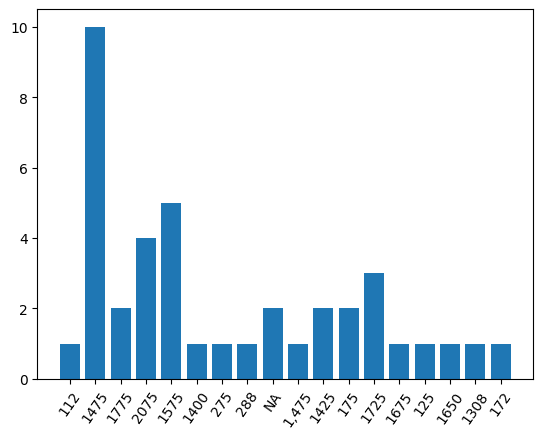

In [24]:
# Thanks to Hans-Christian Fuchs for this.
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(Counter(answers).keys(), Counter(answers).values())
ax.tick_params(axis='x', rotation=55)
plt.show()

### Self-Consistency Advantages

1. Low-effort performance boost.
1. Helps ideate chain-of-thought exemplars.
1. Increased prompt robustness across different LLMs.
1. Provides a pseudo "confidence" estimate based on the answer distributions.
1. Opportunities to use "average" answers for problems without a single correct answer.

### Self-Consistency Disadvantages

1. Increased costs.
1. Slower inference time and/or reduced throughput.


### Self-Consistency Best Practices

1. **Do** Use `temperature=.7`, `top_k=40`, `top_p=1`, and 10 responses as a starting point.
 * **Do** Experiment from there, different use cases may need different values.
 * **Do** Find optimal values for production use cases by conducting a hyperparameter search.
   * Note that it's likely much more valuable to search on the response count than the LLM parameters, and if you do experiment with LLM parameters it's usually not worth reducing them much.
1. **Do** Try self-consistency early if your initial prompt engineering attempts fail.
 * Self-consistency is more likely to boost performance than continuing to engineer your chain of thought prompt.  
1. **Don't** Ignore cost and latency implications.
1. **Do** Parallelize LLM calls to reduce execution time.
 * **Don't** Put off assessing the LLM throughput and latency your self-consistency use case requires.
1. **Do** Use response distributions in creative ways. For example:
 * If fewer than X percent of answers match, flag the question for human review.
 * Generate multiple summaries and use a text similarity metric to identify which generated summary is most "average".
1. **Do** Use self-consistency to inspire few-shot exemplars and to debug your prompt.

# Part 2: Actions, Retrieval, and Tool Use

LLMs, like crows, are adept at using tools.

<img src="./images/3-crow.png">

## Hallucinations, Grounding, and Tools/Actions/Retrieval/RAG
<a name="rag"></a>

LLMs are not reliable sources of facts. When an LLM response contains a correct fact, it is an emergent effect of what the LLM's parameters actually encode: probabilistic relationships between words.

When factual accuracy is important, relying on these probabilistic relationships is risky.

LLMs also cannot (yet) be retrained quickly or cheaply on the latest information. And even when retraining is possible catastrophic forgetting may lead to new errors in older information as the training dataset grows.

When an LLM response is factually incorrect it is often called a "hallucination", though it's more accurately a [delusion](https://en.wikipedia.org/wiki/Delusion).

Hallucinations can be missed by non-experts. LLM responses can be factually incorrect even while the generated text is grammatically accurate, well-formed, and confident in tone.

See what output this LLM call gives:

In [25]:
question = "Who is Chancellor of Germany?"
_ = call_llm(model, parameters, question)

The call to the LLM:
Who is Chancellor of Germany?

The response:
Angela Merkel is the Chancellor of Germany.


The current model may respond correctly, but in August 2023, almost two years after Chancellor Merkel stepped down, this was the response:
<img src="./images/6-hallucinate.png">

The best way to manage hallucinations is to connect an LLM to an accurate and up-to-date external data source.

"Grounding" is using external information to manage hallucinations. One way to "ground" is to insert external information into the LLM call, along with instructions to base the response on the inserted information.

"Retrieval Augmented Generation" or "RAG" is a generic way of saying an LLM uses external knowledge. It can mean different things:
1. An external retrieval system takes a user query as input then outputs information, which is then combined with the user query in the LLM call. (e.g., compare the embedding of the query to the embeddings of documents and insert the closest document into the LLM call). [Code sample](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/document-qa/question_answering_documents_langchain_matching_engine.ipynb).
2. Call an LLM with instructions to formulate a retrieval call to an external information system based on a user's query, then make another call to the LLM combining the user's query and the retrieved information.
3. Coupled bespoke retriever and generator deep learning models trained/tuned together (the focus of the original [RAG paper](https://arxiv.org/pdf/2005.11401.pdf)).

This notebook focuses on #2, and uses the language "tools"/"tool use" to describe instructing an LLM to use an external system, avoiding the ambiguous term RAG. Later in part 3, we'll use "actions" and "acting" to match how ReAct is discussed.

## How LLM Tool Use Works

The basic pattern for LLM tool use is:
1. Make a first LLM call describing:
 * i: The task you want completed.
 * ii: An external  system.
 * iii: How to formulate a call to the external system.
2. Call the external system using the response generated by the LLM.
3. Make a second LLM call that includes the response from the external system, along with instructions for the LLM to complete the original task using the response from the external system.

If our LLM system is supposed to answer fact-based questions like the Chancellor example above:
1. The first LLM call directs the LLM to generate a search query for a knowledge base.
2. The LLM's response is used to query the knowledge base, and the result of the query is captured.
3. The second LLM call includes the result of the knowledge base query, the original question, and instructions for the LLM to answer the question using the result from the knowledge base query.

The LLM's tool can be many things--a database, a web search, a document retrieval system, etc. Part of the LLM system is the code integrating the LLM with the external information source.

In this notebook, we'll use Wikipedia as an external information source and build a basic LLM system to answer fact-based questions. Our LLM system will:
1. Call an LLM to generate a Wikipedia search query.
1. Call the Wikipedia API to retrieve the query result.
1. Call the LLM again with the Wikipedia API response plus the original question.

Beyond the scope of this notebook, LLMs can be called with instructinos describing more than one tool. The LLM both selects the tool and formulates the call to the tool. And LLM tools don't have to be read-only, you can use a tool to interact with an external system (though please consider the ethics and fairness implications--just because you *can* use an LLM to automate an activity doesn't mean you *should*. Hallucinations are annoying when you want to do something like generate a summary, but can be devastating when making a decision that impacts someone's life. Even applications as seemingly innocent as automated paper grading can lead to model failures negatively impacting someone's life).

## The Example Tool

The function below takes a query, returns the top Wikipedia article match for the query, and then retrieves the first `return_chars` characters of the article.

This tool is for teaching purposes and is somewhat limited. It cannot access lists or sidebars, does not handle suggestions well, does not support search within a Wikipedia article, and may not always return a result.

In [26]:
import wikipedia
def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # If no exact match, take Wikipedia's auto-suggestion.
  except wikipedia.exceptions.PageError as e:
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  snippet = page[0:return_chars]
  return snippet

Try the tool:

In [27]:
wiki_tool("chancellor of germany")

'The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established with

## Chaining LLM Calls for Tool Use

A basic two-step tool use LLM chain contains a few pieces, broken down here step-by-step.

If you call the model (as of October 2023) with this example question about an obscure musician it hallucinates an incorrect answer:

In [28]:
question = "What musician released the album 'Somebody in the Snow'?"
_ = call_llm(model, parameters, question)

The call to the LLM:
What musician released the album 'Somebody in the Snow'?

The response:
The musician who released the album 'Somebody in the Snow' is the American singer-songwriter, actress, and model, Taylor Swift. The album was released on October 22, 2012, by Big Machine Records. It is Swift's fifth studio album and was produced by Nathan Chapman and Max Martin. The album debuted at number one on the Billboard 200 chart, selling 1.21 million copies in its first week. It was also the best-selling album of 2012 in the United States. The album received generally positive reviews from critics, with many praising Swift's songwriting and vocal performance. The album spawned four singles: "We Are Never Ever Getting Back Together", "Begin Again", "Red", and "I Knew You Were Trouble". All four singles reached number one on the Billboard Hot 100 chart. The album was nominated for Album of the Year at the 56th Annual Grammy Awards.


### Step 1: Provide the LLM Instructions for Using the Tool

You must provide the LLM both instructions for your task and for how to use the tool.

This "instructions" part of the LLM call is sometimes called the "context" or some variation of "condition" ("conditioning", "conditioning prompt").

In [29]:
context = """Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question."""

### Step 2: Provide An Exemplar

The LLM needs exemplars that show how to use the tool to complete the task.

This example has only a one-shot exemplar, few-shot would be better.

The Wikipedia article text in this exemplar comes from running `wiki_tool("chancellor of germany")` in August 2023.

Note: After future retrainings the LLM will answer this question correctly without an external tool. But this one-shot exemplar will still work, since it shows the pattern of a Wikipedia search, a response, and an answer based on the response.

In [30]:
exemplar = """Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established with the
Answer: Olaf Scholz"""

### Step 3: Make the First Call in the LLM Chain

We'll combine our context and our exemplar together with our question and make a call to the LLM asking for a Wikipedia search query as a response.

In [31]:
step_one_call = f"""{context}

{exemplar}

Question: {question}
Wikipedia Search:"""
step_one_response = call_llm(model, parameters, step_one_call)

The call to the LLM:
Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding

### Step 4: Use the LLM's Response to Query the Tool

Note the LLM response contains more than the Wikipedia search query.

LLMs work by repeatedly predicting the next token over and over again, based on the tokens in the LLM call plus any previously predicted tokens. This means the LLM will generate excess text, it does not know to stop after the Wikipedia search query.

Everything beyond the Wikipedia search query is garbage. The excess text is discarded using the `<STOP>` signifier, though this could also be done with line breaks.

In a production system, it's important to control costs by limiting the response size when making an LLM call like this.

The following function takes the LLM response from the first chain step and returns the Wikipedia query.

In [32]:
def get_wiki_query (llm_response, stop_text = "<STOP>"):
  # Assumes the query is in the first line.
  first_line = llm_response.splitlines()[0]
  query = first_line.split(stop_text)[0]
  return query.strip() # Remove leading and trailing whitespace.

Use this function on the response from the previous LLM call to extract the query, then  use `wiki_tool` to search Wikipedia.

In [33]:
wiki_query = get_wiki_query(step_one_response)
print(f"Tool Query: {wiki_query}")
wiki_text = wiki_tool(wiki_query)
print(f"Wikipedia Snippet: {wiki_text}")

Tool Query: somebody in the snow
Wikipedia Snippet: Jandek is the musical alias of Sterling Smith, a Houston, Texas based American lo-fi folk singer. Since 1978, Jandek has independently released over 45 albums while granting very few interviews and providing no biographical information, releasing on a self-made label "Corwood Industries". Jandek often plays an idiosyncratic and frequently atonal form of folk and blues music, frequently using an open and unconventional chord structure. Allmusic has described him as "the most enigmatic figure in American music".


== History ==
A review of the debut album Ready for the House (1978)  in OP magazine, the first ever national press given to Jandek, referred to the artist as Sterling Smith. Smith has kept his personal history secret, revealing only one story about his pre-Corwood years: he wrote seven novels but burned them upon rejection from New York publishers.In a 1985 interview with John Trubee for Spin, Smith mentioned that he was work

### Step 5: Use the Tool Response to Make the Second Call in the LLM Chain

Next, answer the question by taking the output from the tool and constructing a second LLM call.

LLM tool usage generally maintains the history of the previous calls and responses. To construct the second call in the chain:
1. Start with the first LLM call in the chain.
1. Append the previously generated Wikipedia query.
1. Append the Wikipedia search result.

Here's a reminder of what our first call looked like:

In [34]:
print(step_one_call)

Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He wa

This first LLM call is combined with the query from the first LLM response and the output from the Wikipedia tool, along with structure to match the exemplar:

In [35]:
step_two_call = f"""{step_one_call} {wiki_query}
Wikipedia Article: {wiki_text}
Answer: """
step_two_response = call_llm(model, parameters, step_two_call)

The call to the LLM:
Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding

## Putting All the Steps Together

This code snippet below gathers all the steps above, dependent packages, and dependent functions into a single function that manages the two-step tool usage LLM chain.

You can copy and paste this code into your own project and it should work, assuming you've installed the right packages and authenticated.

In [36]:
import wikipedia

def call_llm(model, parameters, llm_call, show_activity = True):
  # Wraps an LLM call to Vertex, optionally displaying the call and response.
  response = model.predict(llm_call, **parameters).text

  if show_activity:
    BOLD = "\033[1m"
    UNFORMAT = "\033[0m\x1B[0m"
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")
    print(f"{BOLD}The response:{UNFORMAT}")
    print(response)

  return response  # Return to `_` if not needed.


def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # If no exact match, take Wikipedia's suggestion.
  except wikipedia.exceptions.PageError as e:
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  snippet = page[0:return_chars]
  return snippet


def get_wiki_query (llm_response, stop_text = "<STOP>"):
  # Extract the wikipedia query from the LLM response.
  # Assumes the query is in the first line.
  first_line = llm_response.splitlines()[0]
  query = first_line.split(stop_text)[0]
  return query.strip() # Remove leading and trailing whitespace


def wiki_tool_chain(model,
                    parameters,
                    context,
                    exemplar,
                    question,
                    show_activity=False):
  # Answer a query using wikipedia by calling an LLM.
  step_one_call = (
      f"{context}\n\n{exemplar}\n\nQuestion: {question}\nWikipedia Search:"
  )
  if show_activity:
    print("\033[1mMaking the first LLM call...\033[0m\x1B[0m")
  step_one_response = call_llm(model, parameters, step_one_call, show_activity)
  wiki_query = get_wiki_query(step_one_response)
  wiki_text = wiki_tool(wiki_query)

  step_two_call = (
      f"{step_one_call} {wiki_query}\nWikipedia Article: {wiki_text}\nAnswer: "
  )
  if show_activity:
    print("\033[1mMaking the second LLM call...\033[0m\x1B[0m")
  step_two_response = call_llm(model, parameters, step_two_call, show_activity)

  return step_two_response

An example using the code above:


In [37]:
import vertexai
from vertexai.language_models import TextGenerationModel

# Outside this notebook, set PROJECT_ID, LOCATION, and MODEL_NAME.
# When running in the notebook, these are set in part 0.
vertexai.init(project=PROJECT_ID, location=LOCATION)
# These settings control how deterministic the LLM response is.
parameters = {
    "temperature": 0,
    "max_output_tokens": 256,
    "top_p": 0.8,
    "top_k": 40
}
model = TextGenerationModel.from_pretrained(MODEL_NAME)

context = """Answer questions using a lookup of wikipedia.
After each question, write a wikipedia search followed by '<STOP>'.
The wikipedia search will be used to retrieve the most relevant content.
A section of the wikipedia article will then be sent to the next LLM call.
Use the text of the wikipedia article to answer the question."""

exemplar = """Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established with the
Answer: Olaf Scholz"""

answer = wiki_tool_chain(model,
                         parameters,
                         context,
                         exemplar,
                         "What musician released the album 'Somebody in the Snow'?",
                         show_activity = False)
print(answer)


Jandek


With `show_activity = True` to see the breakdown of the LLM calls:

In [38]:
wiki_tool_chain(model,
                parameters,
                context,
                exemplar,
                "What musician released the album 'Somebody in the Snow'?",
                show_activity = True)

Making the first LLM call...
The call to the LLM:
Answer questions using a lookup of wikipedia.
After each question, write a wikipedia search followed by '<STOP>'.
The wikipedia search will be used to retrieve the most relevant content.
A section of the wikipedia article will then be sent to the next LLM call.
Use the text of the wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected

'Jandek'

Try experimenting with changing the `question`. Keep `show_activity = True` to see the two steps in the LLM chain.

This doesn't work well with many questions. As mentioned above, our tool is not very good, and it will fail entirely on some questions.

Tool use best practices are [discussed more in part 3](#react-tools).



# Part 3: ReAct (Reasoning + Acting) Prompting

ReAct (reasoning + actions) combines chain of thought and tool usage together to reason through complex tasks by interacting with external systems.

ReAct-style prompting is currently (Fall 2023) the state-of-the-art for most prompt-driven LLM tasks. When you use plugins or extensions, where an LLM or LLM-based chatbot or system interacts with an external system, you are using a ReAct-style system. In general, any LLM system that reflects up-to-date knowledge is invisibly using ReAct-style functionality under-the-hood.

An LLM attempting to interact with an external system:

<img src="./images/4-robot.png">

## ReAct Basics

ReAct chains typically have three interleaved parts:
- **Thoughts**: Like in chain of thought, these are waypoints, plans, reasoning, etc. generated by the LLM as it makes progress towards the final output.
- **Actions**: LLM-generated commands, calls, or instructions to access an external system. The external system may be a tool that provides information, but can also be more general (i.e., the action observes or changes the state of an external system).
- **Observations**: A response, feedback, result, etc. from the external system, inserted into an LLM call to generate the next thought.

These three steps are repeated until the LLM completes its task.

Similar to chain-of-thought prompting, this repeated cycle forms an "internal monologue" or "inner speech", but with the important addition of decisions to act and feedback from the actions beyond just the reasoning.

### What a ReAct Chain Looks Like

Before breaking down the LLM calls in a ReAct chain, it helps to see what a complete ReAct chain looks like.

The actions in this chain are Wikipedia lookups, and the observations are snippets from the Wikipedia article.

The original call to the LLM is:
```Question: Who was born first, Ronald Regan or Gerald Ford?```(ignoring instructions, exemplars, etc. for now).

The completed ReAct chain looks like this. Scroll to the right to read the full observations:

```
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president. Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]
```

### Breaking Down a ReAct Chain

The example ReAct chain above is constructed from three LLM calls.

Note the responses in this section have been stripped of extra predicted text, similar to how extra text was stripped in the part 2 tool use discussion.

**Call 1:**
```
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1:
```
**Response 1:**
```
I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
```

Each LLM call after the first is:
1. The previous LLM call plus
1. The LLM response to the previous call plus
1. The wikipedia lookup result plus
1. "Thought #:"

**Call 2:**

Call 2 is created by concatenating call 1 + response 1 + the result of the wikipedia lookup (in the observation) + "Thought 2:".
```
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2:
```

**Response 2:**
```
Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
```

**Call 3:**

Just like in call 2, we create call 3 by concatenating call 2 + response 2 + the result of the wikipedia lookup + "Thought 3:".

```
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3:
```

Finally, the LLM returns an answer.

**Response 3:**
```
Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]
```





## Manually Running a ReAct Chain

This section runs a ReAct chain step-by-step.

A few things are required, all in the next code cell:
1. Instructions (context) for the LLM to understand how to do ReAct.
2. At least one exemplar.
3. A tool to execute the LLM's actions.
4. A PaLM API model object to make LLM calls.



In [39]:
context = """Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question."""

exemplar = """Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]"""

# Code for calling Wikipedia.
import wikipedia
def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # If no exact match, take Wikipedia's suggestion.
  except wikipedia.exceptions.PageError as e:
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  snippet = page[0:return_chars]
  return snippet

# Initialized PaLM API model.
import vertexai
from vertexai.language_models import TextGenerationModel

vertexai.init(project=PROJECT_ID, location=LOCATION)
# These settings control how deterministic the LLM response is.
parameters = {
    "temperature": 0,
    "max_output_tokens": 256,
    "top_p": 0.8,
    "top_k": 40
}
model = TextGenerationModel.from_pretrained(MODEL_NAME)


The first LLM call is the context, the exemplar, the question, and a label for the first thought.

The action/thought/observation labels at the start of each line are important to ReAct  chains, and increase the likelihood the LLM response sticks to the "script" of interleaved ReAct steps.

In [40]:
question = "When was the opening year of the theater that debuted Ibsen's 'A Doll's House'?"
llm_call_1 = f"{context}\n\n{exemplar}\n\nQuestion: {question}\nThought 1:"
print(llm_call_1)

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [41]:
response_1 = call_llm(model, parameters, llm_call_1)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

The first and second lines of the response are good. The model generated a reasonable thought and appropriate action.

But just as in the tool use section above, the LLM continues generating garbage text. Remember, LLMs repeatedly predict the next token, and in a ReAct-style LLM call those next tokens are the LLM's prediction of the rest of the ReAct chain.

Just like in the tool use section, extra text is discarded. Only the first two response lines are kept:`Thought 1` and `Action 1`.

In [42]:
# Only take the first two lines of the response.
# Splitlines returns a list with an item for each line.
response_1 = response_1.splitlines()[0:2]
# Turn response 1 into text from the list so we can concatenate to llm call 1.
response_1 = ("\n").join(response_1)
print(response_1)

I need to look up Ibsen's 'A Doll's House' and see where it debuted.
Action 1: A Doll's House<STOP>


Next, query the Wikipedia tool with the LLM's `Action 1` response.

In [43]:
# Look up the LLM's action in Wikipedia.
wiki_text_1 = wiki_tool("A Doll's House")
print(wiki_text_1)

A Doll's House (Danish and Bokmål: Et dukkehjem; also translated as A Doll House) is a three-act play written by Norwegian playwright Henrik Ibsen. It premiered at the Royal Theatre in Copenhagen, Denmark, on 21 December 1879, having been published earlier that month. The play is set in a Norwegian town circa 1879.
The play concerns the fate of a married woman, who at the time in Norway lacked reasonable opportunities for self-fulfillment in a male-dominated world, despite the fact that Ibsen denied it was his intent to write a feminist play. It was a great sensation at the time, and caused a "storm of outraged controversy" that went beyond the theatre to the world of newspapers and society.In 2006, the centennial of Ibsen's death, A Doll's House held the distinction of being the world's most performed play that year. UNESCO has inscribed Ibsen's autographed manuscripts of A Doll's House on the Memory of the World Register in 2001, in recognition of their historical value.The title of 

Then construct the next LLM call by adding the Wikipedia tool output as `Observation 1` and then appending `Thought 2:`.

In [44]:
# Construct the next LLM call.
llm_call_2 = f"{llm_call_1} {response_1}\nObservation 1: {wiki_text_1}\nThought 2:"
print(llm_call_2)

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [45]:
response_2 = call_llm(model, parameters, llm_call_2)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

For the third LLM call in the ReAct chain follow the same procedure as the second call:
1. Take the first two lines of the response.
2. Look up the action in Wikipedia.
3. Assemble the LLM call from the response, the Wikipedia output, and the previous LLM call.

In [46]:
# Only take the first two lines of the response.
# Splitlines returns a list with an item for each line.
response_2 = response_2.splitlines()[0:2]
# Turn response 1 into text from the list so we can concatenate to llm call 1.
response_2 = ("\n").join(response_2)
print(response_2)

Ibsen's 'A Doll's House' premiered at the Royal Theatre in Copenhagen, Denmark. I need to look up the opening year of the Royal Theatre in Copenhagen, Denmark.
Action 2: Royal Theatre in Copenhagen, Denmark<STOP>


In [47]:
# Look up the LLM's action in Wikipedia.
wiki_text_2 = wiki_tool("Royal Theatre in Copenhagen, Denmark")
print(wiki_text_2)

The Royal Danish Theatre (RDT, Danish: Det Kongelige Teater) is both the national Danish performing arts institution and a name used to refer to its old purpose-built venue from 1874 located on Kongens Nytorv in Copenhagen. The theatre was founded in 1748, first serving as the theatre of the king, and then as the theatre of the country. The theatre presents opera, the Royal Danish Ballet, multi-genre concerts, and drama in several locations. The Royal Danish Theatre organization is under the control of the Danish Ministry of Culture.


== Performing arts venues ==
The Old Stage is the original Royal Danish Theatre built in 1874.
The Copenhagen Opera House (Operaen), built in 2004.
Stærekassen (New Stage) is an Art Deco theatre adjacent to the main theatre. It was used for drama productions. It is no longer used by the Royal Theatre.
The Royal Danish Playhouse is a venue for "spoken theatre" with three stages, inaugurated in 2008.


== Cultural references ==
The Royal Theatre on Kongens

In [48]:
# Construct the next LLM call.
llm_call_3 = f"{llm_call_2} {response_2}\nObservation 2: {wiki_text_2}\nThought 3:"
print(llm_call_3)

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [49]:
response_3 = call_llm(model, parameters, llm_call_3)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

And we have an answer!

## A Complete Python Code Snippet for Running ReAct Chains

To use ReAct in an application you need to automate the previous manually-executed steps.

The instructive code snippet below runs ReAct chains. It makes formatted ReAct calls to the LLM, extracts actions, executes actions, detects if the LLM has responded with an answer, and loops.

It's **highly** recommended you walk through the code below and read the comments to better understand how the ReAct chain is automated.

This isn't production-ready code:
1. The snippet is hardcoded to this specific and minimal ReAct example. ReAct chains can look different (more on this later), and useful applications built with ReAct chains  require customized tools.
2. The snippet is brittle, especially the bare-bones Wikipedia tool.
3. The LLM may re-predict previous actions, causing ReAct to infinitely loop. This snippet stops after `max_steps` LLM calls, production ReAct code should catch the loop and attempt to recover.

In [50]:
import wikipedia

def call_llm(model, parameters, llm_call, show_activity = True):
  # Wraps an LLM call to Vertex, optionally displaying the call and response.
  response = model.predict(llm_call, **parameters).text

  if show_activity:
    BOLD = "\033[1m"
    UNFORMAT = "\033[0m\x1B[0m"
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")
    print(f"{BOLD}The response:{UNFORMAT}")
    print(response)
  return response  # Return to `_` if not needed.


def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # If no exact match, take Wikipedia's suggestion.
  except wikipedia.exceptions.PageError as e:
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  snippet = page[0:return_chars]
  return snippet


def wiki_react_chain(model,
                     parameters,
                     context,
                     exemplar,
                     question,
                     max_steps=7,
                     show_activity=False):
  # Call an LLM in a ReACT-style Thought -> Action -> Observation loop.
  # Call the LLM max_steps times or to an answer in the pattern Answer[ans].

  # Construct the first LLM call, teeing up the first thought.
  next_llm_call = f"{context}\n\n{exemplar}\n\nQuestion: {question}\nThought 1:"

  step = 1
  while step <= max_steps:

    if show_activity:
      print(f"\033[1mReAct chain step {step}:\033[0m\x1B[0m")
    llm_response = call_llm(model, parameters, next_llm_call, show_activity)

    # Check for an answer. Look only at the first line of the response, since
    #   the LLM will continue predicting beyond the next thought.
    # This is brittle, it assumes no line breaks in the thought.
    response_first_line = llm_response.splitlines()[0]
    first_line_answer_split = response_first_line.split("Answer[")
    if len(first_line_answer_split) > 1:  # If there's a split on "Answer[".
      # Return the answer, removing the "]" that comes after the answer.
      return first_line_answer_split[1].split("]")[0]

    # If no answer, assume following response line is action.
    response_second_line = llm_response.splitlines()[1]
    """
      Note the hard coded "<STOP>" characters marking the end of the action.
      This isn't strictly necessary if we assume the first line in the LLM
      response is the thought and the second is the action, and that any
      subsequent lines are garbage. But instructing the LLM to explicitly signal
      structure it the response often gives more structurally consistent
      responses, and also makes it easier to detect one way ReAct can fail.
    """
    # Extract the wiki query from the action line of the response.
    wiki_query = response_second_line.split(":")[1].split("<STOP>")[0]
    # Remove leading/trailing whitespace.
    wiki_query = wiki_query.strip()
    if show_activity:
      print(f"\033[1mQuerying wikipedia for: {wiki_query}.\033[0m\x1B[0m")
    wiki_text = wiki_tool(wiki_query)

    # Assemble the next LLM call.
    # Only use the lines of the LLM response with the first thought and action.
    usable_response = f"{response_first_line}\n{response_second_line}"
    # Assemble the wiki response into the observation line.
    obs = f"Observation {step}: {wiki_text}"
    step += 1
    # Previous llm call + the first action and thought in the response +
    # the result of the wikipedia lookup = llm call for next ReAct step.
    # Note that next_llm_call was the last call we made, but we reassign it to
    #   the same variable name so the loop works.
    next_llm_call = f"{next_llm_call} {usable_response}\n{obs}\nThought {step}:"

  # If max_steps exceeded and the loop exits.
  # Would be better to raise an exception.
  return None

An example using the above ReAct chain code snippet.

In [51]:
import vertexai
from vertexai.language_models import TextGenerationModel

# Outside this notebook, set PROJECT_ID, LOCATION, and MODEL_NAME.
# When running in the notebook, these are set in part 0.
vertexai.init(project=PROJECT_ID, location=LOCATION)
# These settings control how deterministic the LLM response is.
parameters = {
    "temperature": 0,
    "max_output_tokens": 256,
    "top_p": 0.8,
    "top_k": 40
}
model = TextGenerationModel.from_pretrained(MODEL_NAME)

context = """Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]"
as part of a thought. Make sure to capitalize "Answer".

Only use information in the observations to answer the question."""

exemplar = """Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]"""

question = "What city was the youngest of the three engineers who designed the Ford T Model born in?"

answer = wiki_react_chain(model,
                          parameters,
                          context,
                          exemplar,
                          question,
                          show_activity = True)
print(answer)


ReAct chain step 1:
The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]"
as part of a thought. Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 

Experiment with changing the `question` above. You may not get great results. This might be due to the brittle Wikipedia tool, but you may see errors with ReAct as well.

Think about how you could improve the performance of the ReAct failures by changing the context or exemplars.

## More ReAct Use Cases

The ReAct pattern does more than answer questions.

With a different context and exemplar, the ReAct code snippet above is adapted for fact checking.

In [52]:
question = "The GDP of Japan is higher than the GDP of BRICS."

context = """You are verifying claims as true or false.
Verify the claim with thoughts, actions, and observations.
Determine if there is an observation that SUPPORTS or REFUTES the claim.

Think about the next action to take to verify the claim. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you reach a conclusion about the claim.
If an observation refutes the claim, return the answer as "Answer[REFUTES]".
If an observation supports the claim, return the answer as "Answer[SUPPORTS]".

Only use information in the observations to answer the question."""

exemplar = """Example:
Claim: Ronald Reagan was born before Gerald Ford.
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. Ronald Reagan was born in 1911. 1911 is before 1913. Ronald Reagan was born before Gerald Ford. Answer[SUPPORTS]"""

answer = wiki_react_chain(model,
                          parameters,
                          context,
                          exemplar,
                          question,
                          show_activity = True)
print(answer)


ReAct chain step 1:
The call to the LLM:
You are verifying claims as true or false.
Verify the claim with thoughts, actions, and observations.
Determine if there is an observation that SUPPORTS or REFUTES the claim.

Think about the next action to take to verify the claim. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you reach a conclusion about the claim.
If an observation refutes the claim, return the answer as "Answer[REFUTES]".
If an observation supports the claim, return the answer as "Answer[SUPPORTS]".

Only use information in

The limitations of the Wikipedia tool limit the utility of this prompt, as does the lack of support for a neutral "not enough information" answer.

But consider how easily ReAct adapted to this use case. The ReAct pattern has also shown good results with:
* Navigating and interacting with text-based virtual worlds.
* Surfing the web.
* Using purchasing instructions to make e-commerce transactions.
* Conducting a literature search of journal articles.


<a name="react-tools"></a>
## Tool Usage Best Practices

If you experimented with the prompts above, you probably experienced failures. In many cases, this is because of the limited Wikipedia tool.

Following some best practices will help you build more robust and effective tools than in this teaching example.

1. **Do** Clearly describe the tool and how to use it in the prompt.
 * This includes few-shot exemplars demonstrating ideal tool use.
 * For example, a tool described as "doc search" will underperform vs. the same tool described as "Search internal documents with a natural language query. The response is a list of document names ordered by descending relevancy to the query."
1. **Do** Carefully consider the scope and complexity of your tools.
 * **Do** Think through if the API to your tool is simple enough for an LLM to use.
 * Often multiple simple tools will work better than one complex tool. What a developer sees as a single API may work better as multiple LLM tools.
 * For example, if your use case requires running SQL to access a database, consider a few separate SQL templates as individual tools vs. using the LLM to generate SQL queries from scratch.
1. **Do** Keep the tool output structurally and stylistically consistent.
 * The less variation in the tool output the more likely the LLM uses the output effectively.
1. **Do** Keep tool output short and relevant.
 * Wordy tool outputs can stress the LLM input length limit.
 * One great example is the [ReAct paper's Wikipedia agent implementation](https://github.com/ysymyth/ReAct/blob/master/wikienv.py), which includes searching within a Wikipedia article and then only returns a snippet of text around the found term rather than the full article.
1. **Do** Handle failures gracefully.
 * **Do** Catch exceptions and provide useful error messages.
 * **Do** Manage tool malfunctions like timeouts and rate limits.
 * **Do** Show error handling in your exemplars.
    * If a tool fails and you provide a useful error in the next LLM call, the LLM may self-correct.
1. **Do** Tune tool usage prompts.
 * A parameter-efficient tuning set with a  variety of tool usage (even only 10s of examples) can improve performance significantly.
1. **Do** Limit the output length when calling an LLM to generate a tool action.
 * The LLM will continue generating text beyond the tool action.
1. **Don't** Forget about security. Many tool usage patterns create security risks.
 * **Do** Assume anything accessible via an LLM's tools will be seen by end users experimenting with adversarial inputs.
 * **Don't** assume your LLM's tool calls will never be malicious. For example, [SQL injection](https://en.wikipedia.org/wiki/SQL_injection) is possible via an LLM tool.

The tool in this notebook does not follow many of these best practices.
1. Wikipedia articles are unpredictable in structure.
1. Wikipedia articles can be 1000s of words but the tool does not support focusing on relevant portions of an article.
1. The prompts do not explain what Wikipedia is or how to use it (though the LLM "knows" what Wikipedia is from its training data).
1. There's no error messages and minimal error handling.

## ReAct Advantages

1. Fewer hallucinations.
 * Grounding with a trusted information source vs. relying on an LLM's "memory".
1. Update/augment LLM knowledge without retraining.
1. Works with off-the-shelf LLMs, no additional LLM training or tuning is required.
1. Supports a variety of use cases.
1. Works with multiple tools.
1. Improving overall system performance by improving tools is often easier than improving a prompt or the LLM itself.

## ReAct Disadvantages

1. Slow (high latency) and expensive, due to  multiple LLM calls.
1. External tools mean more system components to maintain and security concerns.
1. ReAct loops and other non-answer scenarios are common.
 * Vs. chain of thought, where hallucinations are more common.
 * For use cases requiring no specialized or up-to-date information, chain of thought may outperform ReAct.
1. ReAct reasoning (think->act) is less flexible and may underperform vs. the more flexible reasoning of pure chain of thought.
1. When external information is required, more complex than RAG approaches where the retrieval is not controlled by the LLM.
1. Beyond tool integrations, requires additional functionality.
 * Loop bailouts.
 * Managing tool errors.
 * Chain of thought fallbacks.


## ReAct Best Practices

Beyond the [tool use](#react-tools) best practices above.

1. **Do** Use temperature=0.
1. **Don't** Ignore prompt engineering.
 * How you describe the task and tools can change performance considerably.
 * **Do** Test exemplars with labels besides "Thought", "Action", and "Observation", along with skipping steps.
 * **Do** Test exemplars with a variety of thought/reasoning and action styles. For example:
    * Some tasks do best with thoughts that identify the next action, other tasks work best when the first thought formulates a complete plan.
    * Show thoughts/actions that adjust a plan or reconsider a previous thought after an irrelevant observation or tool error.
    * Experiment with thoughts that restate the most salient parts of the prior observation.
1. **Do** Catch ReAct chains stuck in a loop.
 * **Do** Experiment with exemplars showing catching loops.
 * **Do** Catch repeated actions, and consider returning an observation to the LLM calling out the repeated action--the LLM may be able to recover.
 * Try rerunning a looping chain with temperature > 0.
 * When ReAct is the state-of-the-art on a research benchmarking dataset, it's often with a chain of thought self-consistency fallback.
1. **Do** Use fine tuning.
 * **Do** Include tuning examples across the ReAct chain, not just examples of the first or final LLM calls.
 * **Do** Include error/failure handling in tuning data.
 * **Don't** Use tuning examples with incorrect ReAct reasoning, even if the final answer is correct.
1. **Don't** Implement ReAct without first assessing simpler alternatives.  
   * **Do** Consider managed extensions/plugins.
     * An extensions service may provide security, observability, monitoring, evaluation, etc., reducing implementation effort.
     * **Don't** Assume a managed extensions/plugins service meets your needs without a technical assessment.
  * **Do** Consider simpler ways to integrate external knowledge into LLM calls. (i.e., [RAG pattern one above](#rag)).
1. **Do** Use an LLM to debug ReAct at scale.
 * Prompt an LLM to classify failures by type (e.g., reasoning mistake, tool lookup failure, caught in loop) and/or to identify each individual step in the ReAct chain as correct or incorrect.
1. **Do** Include tool functionality in tests, performance measurements (including drift), system monitoring, CI/CD, etc.


# Part 4: Langchain and ReAct
<img src="./images/5-chained.png">

Langchain is a great library for getting started quickly with LLMs. It has a wide variety of useful features, including many [tools integrations](https://python.langchain.com/docs/integrations/tools/) and built-in [ReAct agents](https://python.langchain.com/docs/modules/agents/agent_types/react).

However, ReAct with Langchain may not be the best fit for all use cases. If you use Langchain for a use case it's important to assess if it meets your needs.

Note that even if you find Langchain does not meet the needs of your use case right now, functionality will be added as Langchain approaches a 1.0 release.

Langchain also has proprietary evaluation and production tooling available under the name [Langsmith](https://docs.smith.langchain.com/).

## A Basic Langchain ReAct Agent

The major advantage of ReAct in Langchain is that it's very little work to get started.

In [58]:
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain.llms import VertexAI
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
import wikipedia
import vertexai

# This is the langchain connection to Vertex AI.
# Note this depends on vertexai.init (which was run in Part 0).
llm = VertexAI(model_name=MODEL_NAME, temperature=0)

# Initialize the Wikipedia tool.
_ = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
# This next line invisibly maps to the previous line. The WikipediaQueryRun
#   call is what matters here for Langchain to use its "wikipedia", not
#   the variable that call is output to.
tools = load_tools(["wikipedia"], llm=llm)

# Create the ReAct agent.
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

# You can change this question to see how the agent performs.
# You may get a GuessedAtParserWarning from the wikipedia API, ignore it.
agent.run("What US President costarred with a chimp in 'Bedtime for Bonzo'?")

/root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Ronald Reagan'

Another great feature of Langchain are the built in [tools integrations](https://python.langchain.com/docs/integrations/tools/).

One especially useful tool is for math. LLMs  struggle with math, and having an external calculator improves math performance.

In [60]:
# The answer is 4489.
# This may timeout or error, that's ok.
agent.run("What's 67^2?")

/root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Agent stopped due to iteration limit or time limit.'

In [61]:
# Make the llm-math tool available to the agent.
tools = load_tools(["wikipedia", "llm-math"], llm=llm)
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)
agent.run("What's 67^2?")

'4489'

## Observability Challenges

By default, Langchain returns only the final output of the ReAct chain. But seeing all the LLM calls is sometimes necessary, especially when debugging.

Langchain includes a verbose mode, which provides some observability into underlying LLM calls.

In [62]:
# Note verbose is part of the agent declaration, not the run.
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=True)

agent.run("What US President costarred with a chimp in 'Bedtime for Bonzo'?")



> Entering new AgentExecutor chain...
I need to find out what US President costarred with a chimp in 'Bedtime for Bonzo'
Action: Wikipedia
Action Input: bedtime for bonzo

/root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')



Observation: Page: Bedtime for Bonzo
Summary: Bedtime for Bonzo is a 1951 American comedy film directed by Fred de Cordova and starring Ronald Reagan, Diana Lynn, and a chimpanzee named Peggy as Bonzo. Its central character, psychology professor Peter Boyd (Reagan), tries to teach human morals to a chimpanzee, hoping to solve the "nature versus nurture" question. Boyd hires Jane Linden (Lynn) to pose as the chimpanzee's mother while he plays father to it and uses 1950s-era child-rearing techniques.A sequel was released titled Bonzo Goes to College (1952), but it featured none of the three lead performers from the original film. Peggy, who had also appeared in My Friend Irma Goes West (1950), died in a fire on March 4, 1951, so another chimpanzee was hired for the second film. Reagan did not want to appear in the second film as he thought that the premise was unbelievable.



Page: Bedtime for Democracy
Summary: Bedtime for Democracy is the fourth and final studio album by American pun

'Ronald Reagan'

Here, verbose mode shows that in the first thought the LLM used its internal knowledge.

But verbose mode isn't always sufficient to understand how an agent got to an answer or why an agent failed.

In [63]:
agent.run("What day of the week was September 1st, 2010?")



> Entering new AgentExecutor chain...
I need to know what day of the week September 1st, 2010 was
Action: Calculator
Action Input: 1 September 2010

ValueError: ignored



To fully debug, we need better Langchain internal visibility.

This snippet of custom observability code (from [this notebook](../langchain_observability_snippet/langchain-observability-snippet.ipynb) uses Langchain's [callback handlers](https://python.langchain.com/docs/modules/callbacks/) to show exactly what happens when you run the agent.

In [64]:
# @title
# Import dependencies.
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction, AgentFinish, Document, LLMResult
import pdb
from prettyprinter import cpprint
from typing import Any, Dict, List, Optional, Sequence, Type, Union
from uuid import UUID

# Two helper classes.
class Color():
  """For easier understanding and faster manipulation of printed colors."""
  PURPLE = "\033[95m"
  CYAN = "\033[96m"
  DARKCYAN = "\033[36m"
  BLUE = "\033[94m"
  GREEN = "\033[92m"
  YELLOW = "\033[93m"
  RED = "\033[91m"
  BOLD = "\033[1m"
  UNDERLINE = "\033[4m"
  ITALICS = "\x1B[3m"
  END = "\033[0m\x1B[0m"


class OutputFormatter:
  """ Helper class to control the format of printed output from the callbacks.

  If used in prod, consider reimplementing in a way that removes hardcoding
    of where the output is written. Maybe use Python logging and then pass a
    custom configuration?
  """
  # TODO: Add str casting here to reduce f"{}" in callback class to this class.
  def heading(text: str) -> None:
    print(f"{Color.BOLD}{text}{Color.END}")

  def key_info(text: str) -> None:
    print(f"{Color.BOLD}{Color.DARKCYAN}{text}{Color.END}")

  def key_info_labeled(label: str,
                       contents: str,
                       contents_newlined: Optional[bool] = False
                       ) -> None:
    print(f"{Color.BOLD}{Color.DARKCYAN}{label}: {Color.END}{Color.DARKCYAN}",
          end="")
    if contents_newlined:
      contents = contents.splitlines()
    cpprint(f"{contents}")
    print(f"{Color.END}", end="")

  def debug_info(text: str) -> None:
    print(f"{Color.BLUE}{text}{Color.END}")

  def debug_info_labeled(label: str,
                         contents: str,
                         contents_newlined: Optional[bool] = False
                         ) -> None:
    print(f"{Color.BOLD}{Color.BLUE}{label}: {Color.END}{Color.BLUE}",
          end="")
    if contents_newlined:
      contents = contents.splitlines()
    cpprint(f"{contents}")
    print(f"{Color.END}", end="")

  def llm_call(text: str) -> None:
    print(f"{Color.ITALICS}{text}{Color.END}")

  def llm_output(text: str) -> None:
    print(f"{Color.UNDERLINE}{text}{Color.END}")

  def tool_call(text: str) -> None:
    print(f"{Color.ITALICS}{Color.PURPLE}{text}{Color.END}")

  def tool_output(text: str) -> None:
    print(f"{Color.UNDERLINE}{Color.PURPLE}{text}{Color.END}")

  def debug_error(text: str) -> None:
    print(f"{Color.BOLD}{Color.RED}{text}{Color.END}")

# Actual langchain callback handler, this produces status updates during a
#   langchain execution.
class AllChainDetails(BaseCallbackHandler):
  """Outputs details of chain progress and state.

  Exposes details available at callback time to each executed step in a chain.

  Method arguments in this class are based on the (most of?) the arguments
    available to the callback method, though not all implementations in this
    class use all the arguments.

  Usage:
    Pass as an argument to a langchain method or class that accepts a callback
      handler. Note that  not all langchain classes will invoke all callbacks
      when the callback handler is provided at initialization time, so the
      recommended usage is to provide the callback handler when executing a
      chain.

  Example:
    from langchain import LLMChain, PromptTemplate
    from langchain.llms import VertexAI
    import vertexai  # Comes from google-cloud-aiplatform package.
    vertexai.init(project=PROJECT_ID, location=REGION)

    llm = VertexAI(temperature=0)  # Use any LLM.
    prompt_template = "What food pairs well with {food}?"
    handler = AllChainDetails()
    llm_chain = LLMChain(
      llm=llm,
      prompt=PromptTemplate.from_template(prompt_template))
    llm_chain("chocolate", callbacks=[handler])

  Args:
    debug_mode: If True, prints more details of each chain step and activates
      breakpoints (using pdb) when unexpected behavior is detected. Note that
      the breakpoints are in the callbacks, which limits the amount of
      inspectable langchain state to what langchain surfaces to callbacks.
    out: Class for managing output, only tested with the OutputFormatter
      accompanying this class.
  """
  def __init__(self,
               debug_mode: Optional[bool] = False,
               out: Type[OutputFormatter] = OutputFormatter,
               ) -> None:
    self.debug_mode = debug_mode
    self.out = out

  def on_llm_start(self,
                   serialized: Dict[str, Any],
                   prompts: List[str],
                   **kwargs: Any) -> None:
    """Run when langchain calls an LLM."""
    self.out.heading(f"\n\n> Sending text to the LLM.")

    if len(prompts) > 1:
      self.out.debug_error("prompts has multiple items.")
      self.out.debug_error("Only outputting first item in prompts.")
      if self.debug_mode:
        self.out.debug_info_labeled("Prompts", f"{prompts}")
        pdb.set_trace()

    self.out.key_info(f"Text sent to LLM:")
    self.out.llm_call(prompts[0])

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("serialized", f"{serialized}")

  def on_llm_end(self, response: LLMResult, **kwargs: Any) -> None:
    """Run after LLM response is received by langchain."""
    self.out.heading(f"\n\n> Received response from LLM.")

    if len(response.generations) > 1:
      self.out.debug_error("response object has multiple generations.")
      self.out.debug_error("Only outputting first generation in response.")
      if self.debug_mode:
        self.out.debug_info_labeled("response", f"{response}")
        pdb.set_trace()

    self.out.key_info(f"Text received from LLM:")
    self.out.llm_output(response.generations[0][0].text)

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("response", f"{response}")

  def on_tool_start(self,
                    serialized: Dict[str, Any],
                    input_str: str,
                    **kwargs: Any,) -> None:
    """Run when making a call to a tool."""
    self.out.heading(f"\n\n> Using tool.")
    self.out.key_info_labeled(f"Tool name", f"{serialized['name']}")
    self.out.key_info(f"Query sent to tool:")
    self.out.tool_call(input_str)

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("serialized", f"{serialized}")

  def on_tool_end(
      self,
      output: str,
      color: Optional[str] = None,
      observation_prefix: Optional[str] = None,
      llm_prefix: Optional[str] = None,
      **kwargs: Any,) -> None:
    """Run on response from a tool."""
    self.out.heading(f"\n\n> Received tool output.")
    self.out.key_info_labeled(f"Tool name", f"{kwargs['name']}")

    if "output" not in locals():
      self.out.debug_error("No tool output.")
      if self.debug_mode:
        pdb.set_trace()
    else:
      self.out.key_info("Response from tool:")
      self.out.tool_output(f"{output}")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("observation_prefix",
                                  f"{observation_prefix}")
      self.out.debug_info_labeled("llm_prefix",
                                  f"{llm_prefix}")

  def on_agent_action(self,
                      action: AgentAction,
                      color: Optional[str] = None,
                      **kwargs: Any) -> Any:
    """Run when agent performs an action."""
    self.out.heading(f"\n\n> Agent taking an action.")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("action", f"{action}")

  def on_agent_finish(self,
                      finish: AgentFinish,
                      color: Optional[str] = None,
                      **kwargs: Any) -> None:
    """Run after agent completes."""
    self.out.heading(f"\n\n> Agent has finished.")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("finish",
                                  f"{finish}")

  def on_llm_error(self,
                   error: Union[Exception, KeyboardInterrupt],
                   **kwargs: Any) -> None:
    self.out.debug_error("LLM Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

  def on_chain_error(self,
                     error: Union[Exception, KeyboardInterrupt],
                     **kwargs: Any) -> None:
    self.out.debug_error("Chain Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

  def on_tool_error(self,
                    error: Union[Exception, KeyboardInterrupt],
                    **kwargs: Any) -> None:
    self.out.debug_error("Chain Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

Repeat the failed query using an agent that includes the custom observability code.

In [65]:
handler = AllChainDetails()
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)
agent.run("What day of the week was September 1st, 2010?",
          callbacks=[handler])



> Sending text to the LLM.
Text sent to LLM:
Answer the following questions as best you can. You have access to the following tools:

Wikipedia: A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
Calculator: Useful for when you need to answer questions about math.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [Wikipedia, Calculator]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: What day of the week was September 1st, 2010?
Thought:


> Received response from LLM.
Text received from LLM:
I need to know what day of

ValueError: ignored

The exact calls sent to the LLM are shown, along with when the LLM selects a tool ("Using tool"), the LLM's input to the tool ("Query sent to tool:"), and the following LLM activity.

The nature of the error is now clearer: the math tool instructs the LLM to produce an expression to run with the`numexpr` library, but the LLM mistakenly includes the `datetime` library in the expression.

Additionally, the LLM calls Langchain uses to run ReAct, including the tool descriptions and exact ReAct implementation (which differs from the standard Thought -> Action -> Observation) are viewable.

### Production Observability in Langchain

To run a stable production LLM system, you need strong observability and logging, probably in an centralized external logging/monitoring platform. Without this, you cannot be sure your system is running correctly and you may not be able to debug.

Langchain's callbacks implementation is helpful here, and some ML platform vendors have provided Langchain callback handlers.

But some use cases require crafting a custom Langchain callback handler, and depending on what other parts of the Langchain module your system relies on you may have to make changes to Langchain internals to surface the necessary information into the callbacks.

## Tool Customization Friction

Some ways to add `datetime` support to your Langchain agent are:

1. Change how the math tool is described in the ReAct prompt, so the LLM knows not to use `datetime`.
1. Create a new tool specifically for datetime operations, and make it available to the LLM.
1. Modify the Langchain math tool to add `datetime` support.
1. Modify the Langchain math tool to catch the exception from `numexpr`, and then provide an error message to the LLM in the next call so the LLM can take a different action.

These require knowledge of Langchain internals and/or using Langchain features that aren't yet documented.

Additionally, for best ReAct performance you'll need to adjust the instructions, the exemplars, and the tool descriptions. This means that beyond managing the `datetime` tool issues, you'll need to create a [custom Langchain agent](https://python.langchain.com/docs/modules/agents/).

In many use cases, this friction will be worth overcoming. But like with any decision to adopt a framework, follow software development best practices and fully investigate the pros and cons of available frameworks and building from scratch.

# What Next?

[Fill out this short feedback form](https://forms.gle/YZeSDMXPpVRS6Fe2A) to let us know what additional prompt engineering topics you want to learn more about.